In [1]:
# 1. Load libraries  
import pandas as pd  
import numpy as np  
from sklearn.model_selection import train_test_split  
from sklearn.metrics import mean_squared_error, r2_score  
from sklearn.preprocessing import StandardScaler  
from xgboost import XGBRegressor  
from sklearn.feature_selection import RFE  
import matplotlib.pyplot as plt  
import seaborn as sns  
import joblib  

In [2]:
# 2. Load dataset  
df = pd.read_csv("cleaned_hour_no_outliers.csv")  

In [5]:
# 3. Preprocessing  
df = df.drop(['instant', 'dteday','yr', 'casual', 'registered'], axis=1)  
  
# Define features and target  
X = df.drop('cnt', axis=1)  
y = df['cnt']  

In [7]:
# 4. Train-Test Split  
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  


In [9]:
# 5. Initial Model for Feature Selection  
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)  
  
# Scale all features temporarily for RFE  
scaler_temp = StandardScaler()
X_train_scaled_temp = scaler_temp.fit_transform(X_train_raw)

# Feature selection on scaled data  
rfe = RFE(estimator=xgb_model, n_features_to_select=7)
rfe.fit(X_train_scaled_temp, y_train)

# Get selected feature names  
selected_features = X.columns[rfe.support_]
print("Selected Features by RFE:", list(selected_features))


Selected Features by RFE: ['season', 'hr', 'workingday', 'weathersit', 'temp', 'atemp', 'hum']


In [11]:
# 6. Extract only selected features for retraining  
X_train_sel = X_train_raw[selected_features]
X_test_sel = X_test_raw[selected_features]

In [13]:
# 7. Fit a new scaler ONLY on selected features  
final_scaler = StandardScaler()
X_train_scaled = final_scaler.fit_transform(X_train_sel)
X_test_scaled = final_scaler.transform(X_test_sel)

In [15]:
# 8. Retrain model using only selected, scaled features  
final_model = XGBRegressor(objective='reg:squarederror', random_state=42)
final_model.fit(X_train_scaled, y_train)
y_pred_sel = final_model.predict(X_test_scaled)


In [17]:
# 9. Evaluation  
print("\nFinal Model Performance with Selected Features:")
print("R2 Score:", r2_score(y_test, y_pred_sel))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_sel)))


Final Model Performance with Selected Features:
R2 Score: 0.855164654014737
RMSE: 64.17617668897967


In [19]:

# 10. Save final artifacts  
joblib.dump(final_model, 'Final_Project_Model.pkl')
joblib.dump(final_scaler, 'final_scaler.pkl')
joblib.dump(list(selected_features), 'selected_features.pkl')


['selected_features.pkl']

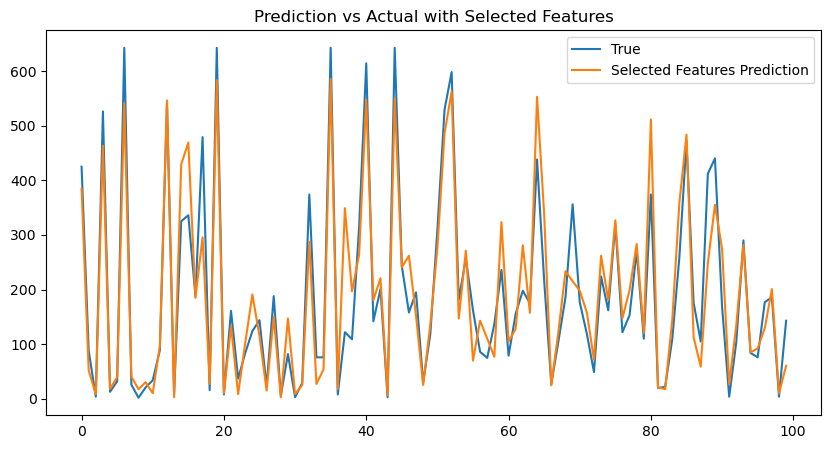

In [21]:
# 11. Optional: Plot Comparison  
plt.figure(figsize=(10, 5))
plt.plot(y_test.values[:100], label='True')
plt.plot(y_pred_sel[:100], label='Selected Features Prediction')
plt.legend()
plt.title("Prediction vs Actual with Selected Features")
plt.show()